###Importação dos Pacotes

In [19]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DoubleType, IntegerType
from functools import reduce
import os
import urllib.request
import requests
import gzip
import tarfile
import shutil
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency

###Inicializa a sessão Spark

In [20]:
spark = SparkSession.builder \
    .appName("iFood AB Data Load") \
    .getOrCreate()

# Diretório temporário para armazenar os dados
os.makedirs("dados", exist_ok=True)

###Extração das Bases de Dados

Criando uma função para fazer o download das bases de dados e descompactá-las

In [21]:
def baixar_arquivo(url, caminho_destino):
    if not os.path.exists(caminho_destino):
        print(f"Baixando {url.split('/')[-1]} ...")
        urllib.request.urlretrieve(url, caminho_destino)
    else:
        print(f"{caminho_destino} já existe. Pulando download.")

In [22]:
# 1. Orders (JSON.GZ)
orders_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"
orders_gz = "dados/order.json.gz"
orders_json = "dados/order.json"
baixar_arquivo(orders_url, orders_gz)
if not os.path.exists(orders_json):
    with gzip.open(orders_gz, 'rb') as f_in, open(orders_json, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
df_orders = spark.read.json(orders_json)
print(f"df_orders: {df_orders.count()} linhas, {len(df_orders.columns)} colunas")

# 2. Customers (CSV.GZ)
customers_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz"
customers_gz = "dados/consumer.csv.gz"
customers_csv = "dados/consumer.csv"
baixar_arquivo(customers_url, customers_gz)
if not os.path.exists(customers_csv):
    with gzip.open(customers_gz, 'rb') as f_in, open(customers_csv, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
df_customers = spark.read.csv(customers_csv, header=True, inferSchema=True)
print(f"df_customers: {df_customers.count()} linhas, {len(df_customers.columns)} colunas")

# 3. Merchants (CSV.GZ)
merchants_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
merchants_gz = "dados/restaurant.csv.gz"
merchants_csv = "dados/restaurant.csv"
baixar_arquivo(merchants_url, merchants_gz)
if not os.path.exists(merchants_csv):
    with gzip.open(merchants_gz, 'rb') as f_in, open(merchants_csv, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
df_merchants = spark.read.csv(merchants_csv, header=True, inferSchema=True)
print(f"df_merchants: {df_merchants.count()} linhas, {len(df_merchants.columns)} colunas")

# 4. Test_AB (TAR.GZ com CSV dentro)
test_ab_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"
test_ab_tar = "dados/ab_test_ref.tar.gz"
baixar_arquivo(test_ab_url, test_ab_tar)
with tarfile.open(test_ab_tar, "r:gz") as tar:
    tar.extractall(path="dados")

# Busca recursiva por CSV extraído
test_ab_csv = None
for root, dirs, files in os.walk("dados"):
    for file in files:
        if file.endswith(".csv") and file.startswith("ab_test_ref"):
            test_ab_csv = os.path.join(root, file)
            break
    if test_ab_csv:
        break
if not test_ab_csv:
    raise FileNotFoundError("Arquivo ab_test_ref.csv não encontrado após a extração do TAR.GZ.")
df_test_ab = spark.read.csv(test_ab_csv, header=True, inferSchema=True)
print(f"df_test_ab: {df_test_ab.count()} linhas, {len(df_test_ab.columns)} colunas")

dados/order.json.gz já existe. Pulando download.
df_orders: 3670826 linhas, 22 colunas
dados/consumer.csv.gz já existe. Pulando download.
df_customers: 806156 linhas, 7 colunas
dados/restaurant.csv.gz já existe. Pulando download.
df_merchants: 7292 linhas, 12 colunas
dados/ab_test_ref.tar.gz já existe. Pulando download.
df_test_ab: 806467 linhas, 2 colunas


Base: **Pedidos**

In [23]:
df_orders.show()

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

A coluna items do df_orders consiste em uma lista de dicionários, ou seja, cada pedido pode conter vários itens produtos. Para analisar item por item de forma estruturada, faremos um split dessa coluna:

In [24]:
"""
df_orders_raw = spark.read.json(order_path)

# Define the schema for the items in the 'items' column
items_schema = ArrayType(StructType([
    StructField("name", StringType(), True),
    StructField("id", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("quantity", IntegerType(), True)
]))

# Parse the JSON string in the 'items' column and cast it to the defined schema
df_orders_parsed = df_orders_raw.withColumn("items_parsed", from_json(col("items"), items_schema))

# Explode the parsed 'items' column
df_orders_exploded = df_orders_parsed.withColumn("item", explode(col("items_parsed")))

# Select and rename the columns
df_orders = df_orders_exploded.select(
    "order_id",
    "customer_id",
    "merchant_id",
    col("order_created_at").alias("created_at"), # Renamed order_created_at to created_at based on the original select
    # Assuming 'status' is intended to be selected, but it's not in the raw dataframe.
    # I'll keep the original select's columns for now and remove status.
    col("item.id").alias("item_id"),
    col("item.name").alias("item_name"),
    col("item.price").alias("item_price"),
    col("item.quantity").alias("item_quantity"),
    col("order_total_amount")
)

df_orders.show()
"""

'\ndf_orders_raw = spark.read.json(order_path)\n\n# Define the schema for the items in the \'items\' column\nitems_schema = ArrayType(StructType([\n    StructField("name", StringType(), True),\n    StructField("id", StringType(), True),\n    StructField("price", DoubleType(), True),\n    StructField("quantity", IntegerType(), True)\n]))\n\n# Parse the JSON string in the \'items\' column and cast it to the defined schema\ndf_orders_parsed = df_orders_raw.withColumn("items_parsed", from_json(col("items"), items_schema))\n\n# Explode the parsed \'items\' column\ndf_orders_exploded = df_orders_parsed.withColumn("item", explode(col("items_parsed")))\n\n# Select and rename the columns\ndf_orders = df_orders_exploded.select(\n    "order_id",\n    "customer_id",\n    "merchant_id",\n    col("order_created_at").alias("created_at"), # Renamed order_created_at to created_at based on the original select\n    # Assuming \'status\' is intended to be selected, but it\'s not in the raw dataframe.\n   

Base: **Usuários**

In [25]:
df_customers.show()

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 14:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14 21:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07 03:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 22:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-06 00:16:...|  true|       WENDER|                 76|            543232158|
|77e6a36569f6c8f35...|   pt-br|2018-01-27 20:00:...|  true|     MICHELLE

Base: **Merchants**

In [26]:
df_merchants.show()

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23 12:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20 13:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23 12:46:...|  

Base: **Teste A/B**

In [27]:
df_test_ab.show()

+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
|b821aa8372b8e5b82...|  control|
|d425d6ee4c9d4e211...|  control|
|6a7089eea0a5dc294...|   target|
|dad6b7e222bab31c0...|  control|
|82905a7d1fe78f80c...|   target|
|2c793590086a05d39...|   target|
|2c2c1ec8e79d1b98e...|   target|
|5994c3c2c48edd8a7...|   target|
|657d1330fd2b28abd...|  control|
|4ab5c66a5fbc0ccb3...|   target|
|1b669bd4b720ea0a4...|  control|
|c58d1b6ed9e7bb94a...|   target|
|5841e1fbd518d7a63...|   target|
|df4a3b2f7c0e259ad...|  control|
|d7974cdc3736cea24...|   target|
|f8dcc804aa970d381...|  control|
|fdf3cbc1ae5f2441c...|   target|
|e3c10f0f467527d2a...|  control|
|2c662e08a33f3b0c7...|   target|
+--------------------+---------+
only showing top 20 rows



###Análise de Impacto da Campanha

In [28]:
# Juntando a base de pedidos com a de marcações da campanha
df_orders_ab = df_orders.join(df_test_ab, on="customer_id", how="inner")

# Cacheando porque será usado várias vezes
df_orders_ab.cache()
df_orders_ab.count()  # Força a execução para materializar o cache

3662321

Indicadores para mensurar sucesso:

**Taxa de conversão:** % de usuários de cada grupo que fizeram pelo menos um pedido no período.

**Ticket médio:** valor médio gasto por pedido.

**Pedidos por usuário:** número médio de pedidos por usuário.

**Receita total:** soma dos valores de todos os pedidos por grupo.

Esses indicadores mostram:

*   Se o cupom gerou mais pedidos (conversão);
*   Se aumentou o gasto médio ou só incentivou compras pequenas;
*   Se realmente trouxe mais receita;

In [29]:



# Total de usuários em cada grupo
n_users = df_test_ab.groupBy('is_target').agg(F.countDistinct('customer_id').alias('n_users'))

# Usuários que fizeram ao menos um pedido (compradores)
buyers = df_orders_ab.groupBy('is_target').agg(F.countDistinct(F.when(F.col("order_total_amount") > 0, F.col("customer_id"))).alias("n_buyers"))

# Ticket médio: média do valor dos pedidos
avg_ticket = df_orders_ab.groupBy('is_target').agg(F.avg('order_total_amount').alias('avg_ticket'))

# Total de pedidos por grupo
total_orders = df_orders_ab.groupBy('is_target').agg(F.count('order_id').alias('total_orders'))

# Receita total por grupo
total_revenue = df_orders_ab.groupBy('is_target').agg(F.sum('order_total_amount').alias('total_revenue'))

# Pedidos por usuário (média)
orders_per_user = total_orders.join(n_users, on='is_target')\
                              .withColumn('orders_per_user', F.col('total_orders') / F.col('n_users'))\
                              .select('is_target', 'orders_per_user')

# Taxa de conversão: % de usuários que fizeram pedido
conversion = buyers.join(n_users, on='is_target')\
                   .withColumn('conversion_rate', F.col('n_buyers') / F.col('n_users'))\
                   .select('is_target', 'conversion_rate')

# Consolidando em um único DataFrame
results = n_users\
    .join(buyers, on='is_target')\
    .join(conversion, on='is_target')\
    .join(avg_ticket, on='is_target')\
    .join(orders_per_user, on='is_target')\
    .join(total_revenue, on='is_target')

# Adicionar colunas formatadas ao DataFrame de resultados
results_formatted = results\
    .withColumn(
        "n_users_fmt",
        F.round(F.col("n_users"), 1)
    )\
    .withColumn(
        "n_buyers_fmt",
        F.round(F.col("n_buyers"), 1)
    )\
    .withColumn(
        "conversion_rate_fmt",
        F.concat(F.round(F.col("conversion_rate") * 100, 4), F.lit("%"))
    )\
    .withColumn(
        "avg_ticket_fmt",
        F.concat(F.lit("R$ "), F.format_number("avg_ticket", 2))
    )\
    .withColumn(
        "orders_per_user_fmt",
        F.round(F.col("orders_per_user"), 1)
    )\
    .withColumn(
        "total_revenue_fmt",
        F.concat(F.lit("R$ "), F.format_number("total_revenue", 2))
    )

results_formatted.select(
    "is_target",
    "n_users",
    "n_buyers",
    "conversion_rate_fmt",
    "avg_ticket_fmt",
    "orders_per_user_fmt",
    "total_revenue_fmt"
).show(truncate=False)

+---------+-------+--------+-------------------+--------------+-------------------+-----------------+
|is_target|n_users|n_buyers|conversion_rate_fmt|avg_ticket_fmt|orders_per_user_fmt|total_revenue_fmt|
+---------+-------+--------+-------------------+--------------+-------------------+-----------------+
|control  |360542 |360528  |99.9961%           |R$ 47.90      |4.2                |R$ 73,071,872.88 |
|target   |445925 |445909  |99.9964%           |R$ 47.74      |4.8                |R$ 102,007,569.84|
+---------+-------+--------+-------------------+--------------+-------------------+-----------------+



**Taxa de conversão:** Está praticamente em 100% nos dois grupos (considerando a premissa de que um pedido válido possui valor maior que 0 reais). Isso sugere que todos os usuários do recorte analisado realizaram pelo menos um pedido. Em situações reais, normalmente há uma diferença aqui, o que pode indicar algum viés ou característica da amostra;

**Ticket médio:** Muito semelhante entre os grupos, sem diferenças relevantes;

**Pedidos por usuário:** Superior no grupo teste, sugerindo maior engajamento/recorrência (4,8 *versus* 4,2).

**Receita total:** O grupo teste gerou receita significativamente maior.

A campanha de cupons **teve impacto relevante em engajamento (número de pedidos) o que se traduziu em maior faturamento** ainda que o efeito no ticket médio pareça insignificante. O efeito principal parece ser aumento de frequência, mais do que atração de novos compradores (já que todos compraram pelo menos uma vez).

Vamos confirmar estatisticamente (através de testes adequados) se os insights e conclusões que obtivemos podem ser tomados como hipóteses válidas:

Ticket Médio: estatística = 0.804, p-valor = 0.4213
Total Gasto: estatística = -24.319, p-valor = 0.0000
Qtd. Pedidos: estatística = -44.253, p-valor = 0.0000
Retenção (chi2): estatística = 2622.147, p-valor = 0.0000


/tmp/ipython-input-30-2944567794.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control['avg_ticket'], target['avg_ticket']], labels=['Control', 'Target'])


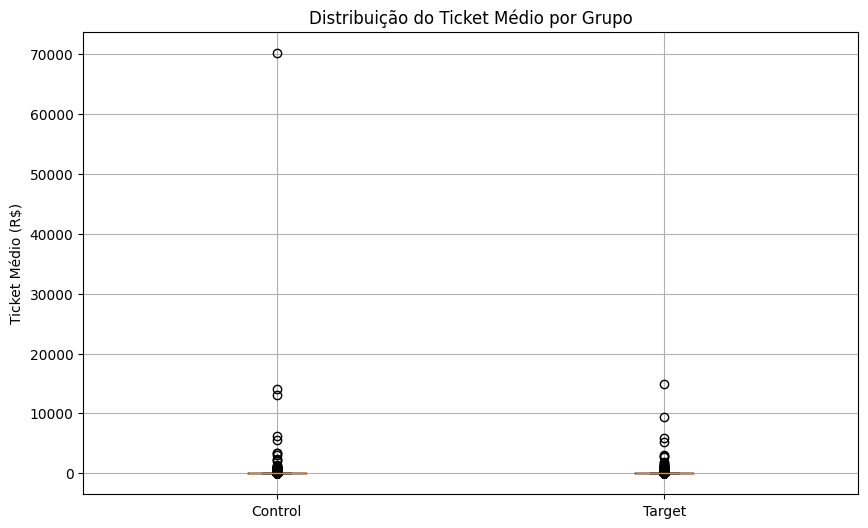

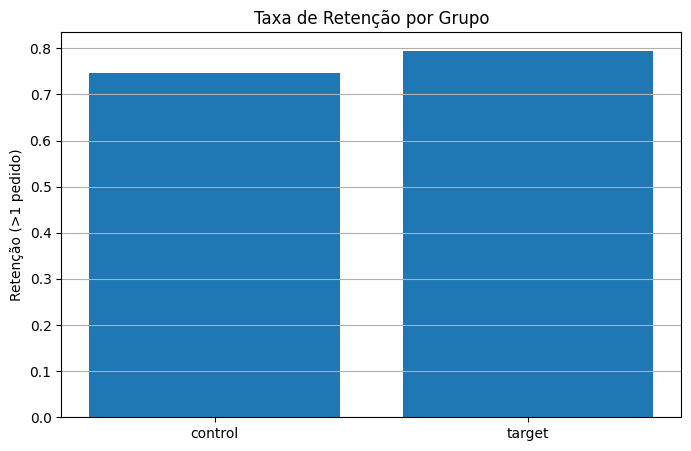

In [30]:


# Join dos dados
df = df_orders_ab.join(df_customers.select("customer_id", "created_at"), on="customer_id", how="inner")

# Agregações por usuário
user_stats = df.groupBy("customer_id", "is_target").agg(
    F.count("order_id").alias("order_count"),
    F.sum("order_total_amount").alias("total_spent"),
    F.avg("order_total_amount").alias("avg_ticket"),
    F.min("order_created_at").alias("first_order"),
    F.max("order_created_at").alias("last_order")
)

# Retenção
user_stats = user_stats.withColumn("retained", F.when(F.col("order_count") > 1, 1).otherwise(0))

# Converter para Pandas para testes e gráficos
user_pd = user_stats.toPandas()
control = user_pd[user_pd['is_target'] == 'control']
target = user_pd[user_pd['is_target'] == 'target']

# Testes estatísticos
results = {
    "Ticket Médio": ttest_ind(control['avg_ticket'], target['avg_ticket'], equal_var=False),
    "Total Gasto": ttest_ind(control['total_spent'], target['total_spent'], equal_var=False),
    "Qtd. Pedidos": ttest_ind(control['order_count'], target['order_count'], equal_var=False),
}

# Teste de proporção para retenção
ret_table = pd.crosstab(user_pd['is_target'], user_pd['retained'])
chi2, p_ret, _, _ = chi2_contingency(ret_table)

results["Retenção (chi2)"] = (chi2, p_ret)

# Exibir resultados
for key, value in results.items():
    print(f"{key}: estatística = {value[0]:.3f}, p-valor = {value[1]:.4f}")

# Gráficos
plt.figure(figsize=(10, 6))
plt.boxplot([control['avg_ticket'], target['avg_ticket']], labels=['Control', 'Target'])
plt.title('Distribuição do Ticket Médio por Grupo')
plt.ylabel('Ticket Médio (R$)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
retention_rates = ret_table[1] / ret_table.sum(axis=1)
plt.bar(retention_rates.index, retention_rates.values)
plt.title('Taxa de Retenção por Grupo')
plt.ylabel('Retenção (>1 pedido)')
plt.grid(axis='y')
plt.show()


Ticket médio: sem significância estatística (p-value > 0.05) portanto, o cupom não alterou o valor médio dos pedidos.

Total gasto: com significância estatística (p-value < 0.05), usuários do grupo controle gastaram menos no total. O cupom gerou aumento no gasto total.

Quantidade de Pedidos: com significância estatística (p-value < 0.05),usuários com cupom fizeram mais pedidos.

Retenção: com significância estatística (p-value < 0.05),cupom aumentou significativamente a chance de o usuário fazer mais de 1 pedido.

Portanto, **embora estatisticamente eficaz**, a campanha **não é viável financeiramente**, a menos que o cupom seja mais barato ou seja direcionado a segmentos com maior retorno.

In [ ]:
# Limpando os dataframes em cache para liberar memória
spark.catalog.clearCache()

###Análise de Viabilidade Financeira

**Premissas:**

Valor do cupom médio concedido por compra: R$ 10

Margem líquida da operação sobre o valor dos pedidos: 15%

O aumento de 0,6 pedidos por usuário do grupo teste (diferença entre 4,8 e 4,2) foi efeito da campanha

In [ ]:
# Parâmetros
valor_cupom = 10
margem_liquida = 0.15

# Limpa avg_ticket
results_spark = results.withColumn(
    "avg_ticket", F.regexp_replace("avg_ticket", "R\$ ", "").cast("double")
)

# Cria um DataFrame com valores de target e control
joined = (
    results_spark
    .filter(F.col("is_target").isin(["target", "control"]))
    .select(
        F.col("is_target"),
        F.col("orders_per_user").alias("orders_per_user"),
        F.col("n_users").alias("n_users"),
        F.col("avg_ticket").alias("avg_ticket"),
    )
    .groupBy()
    .agg(
        F.max(F.when(F.col("is_target") == "target", F.col("orders_per_user"))).alias("orders_per_user_target"),
        F.max(F.when(F.col("is_target") == "control", F.col("orders_per_user"))).alias("orders_per_user_control"),
        F.max(F.when(F.col("is_target") == "target", F.col("n_users"))).alias("n_users_target"),
        F.max(F.when(F.col("is_target") == "target", F.col("avg_ticket"))).alias("avg_ticket_target"),
    )
)

# Calcula os indicadores
final_df = (
    joined
    .withColumn("pedidos_incr", F.col("orders_per_user_target") - F.col("orders_per_user_control"))
    .withColumn("total_pedidos_incr", F.col("pedidos_incr") * F.col("n_users_target"))
    .withColumn("receita_incremental", F.col("total_pedidos_incr") * F.col("avg_ticket_target"))
    .withColumn("custo_campanha", F.col("total_pedidos_incr") * F.lit(valor_cupom))
    .withColumn("lucro_incremental", (F.col("receita_incremental") * F.lit(margem_liquida)) - F.col("custo_campanha"))
)

# Resultados
final_df.select(
    F.round("receita_incremental", 2).alias("Receita incremental"),
    F.round("custo_campanha", 2).alias("Custo campanha"),
    F.round("lucro_incremental", 2).alias("Lucro incremental"),
).show()


+-------------------+--------------+-----------------+
|Receita incremental|Custo campanha|Lucro incremental|
+-------------------+--------------+-----------------+
|      1.192940903E7|    2498844.46|       -709433.11|
+-------------------+--------------+-----------------+



A campanha, com as premissas adotadas (cupom de R$ 10 e margem de 15%), **não se pagou**: houve aumento de frequência de pedidos e receita, mas o custo dos cupons excedeu o lucro gerado, **gerando prejuízo incremental**.

Se a margem operacional ou o valor do cupom fossem diferentes, o resultado poderia mudar.

Esse é um alerta para calibrar o valor do incentivo em campanhas desse tipo, buscar maior eficiência, ou aumentar o foco em clientes de maior potencial.

###Desenho de novo teste A/B

**Oportunidades de Melhoria**

**Segmentação:** O cupom poderia ser oferecido para segmentos com maior potencial de crescimento (ex: clientes inativos, ou com menor frequência histórica).

**Cupom gradativo:** Oferecer incentivos proporcionais ao valor do pedido, ou apenas para valores acima de um mínimo, evitando assim estratégias de "substituição" de compras maiores por pequenas compras por parte dos clientes.

**Limitar uso:** Restringir os cupons a utilizações únicas e com prazos de expiração. Evitando abusos, gerando fidelização e maximizando o retorno.

**Teste de diferentes valores de cupom:** Avaliar elasticidade ao valor do incentivo, buscando o ponto de maior retorno financeiro.

**Mensuração de comportamento após a campanha:** Avaliar se o aumento de frequência se mantém após o fim da campanha, ou se é só temporário.

Vamos então propor 3 cenários de teste para efetuarmos comparações. São eles:

**GRUPOS:**

**Controle:** Sem cupom

**Cenário 1:** Cupom fixo de R$ 5

**Cenário 2:** Cupom fixo de R$ 10

**Cenário 3:** Cupom de R$ 10 para pedidos acima de 50 reais

**CRITÉRIOS DE ANÁLISE:**

*   Taxa de conversão, ticket médio, pedidos por usuário, receita total, margem e ROI da campanha;

*   Acompanhamento por segmento de cliente (ex: frequência anterior, ticket anterior).







**HIPÓTESES:**

1.   Qual valor de cupom gera maior ROI?
2.   Um valor mínimo de compra alavanca mais receita/margem?
3.   Segmentos de clientes respondem de forma diferente ao incentivo?

In [ ]:
# 1. Amostragem aleatória de 5%
df_sample = df_orders.sample(False, 0.05, seed=42).cache()

# Calcula o restaurante favorito (maior número de pedidos) por cliente
fav_rest = (
    df_orders
    .groupBy('customer_id', 'merchant_id')
    .agg(F.count('order_id').alias('n_orders'))
)
w = Window.partitionBy('customer_id').orderBy(F.desc('n_orders'))
fav_rest = (
    fav_rest.withColumn('rn', F.row_number().over(w))
    .filter(F.col('rn') == 1)
    .select('customer_id', F.col('merchant_id').alias('fav_restaurant_id'))
)

df_ab = (
    df_sample
    .join(fav_rest, 'customer_id', 'left')
    .join(df_customers.select('customer_id', 'active'), 'customer_id', 'inner')
    .select(
        df_sample['customer_id'],
        df_sample['order_id'],
        df_sample['order_total_amount'],
        df_sample['merchant_id'],
        fav_rest['fav_restaurant_id'],
        df_customers['active']
    )
)


# Adiciona coluna randômica e distribui grupos igualmente (~25% para cada)
df_ab = df_ab.withColumn('rand', F.rand(seed=42))
ntile_window = Window.orderBy('rand')
df_ab = df_ab.withColumn('ab_group', F.ntile(4).over(ntile_window))

# Define o grupo inicial
df_ab = df_ab.withColumn(
    'is_target',
    F.when(F.col('ab_group') == 1, 'controle')
     .when(F.col('ab_group') == 2, 'cenario_1')
     .when(F.col('ab_group') == 3, 'cenario_2')
     .otherwise('cenario_3')
)

# Reajusta regras para garantir elegibilidade
df_ab = df_ab.withColumn(
    'is_target',
    F.when(
        (F.col('is_target') == 'cenario_1') & (F.col('order_total_amount') <= 50), 'controle'
    ).when(
        (F.col('is_target') == 'cenario_2') & (F.col('active') != True), 'controle'
    ).when(
        (F.col('is_target') == 'cenario_3') & (F.col('merchant_id') != F.col('fav_restaurant_id')), 'controle'
    ).otherwise(F.col('is_target'))
)


# Coluna para cupom_usado por grupo
df_ab = df_ab.withColumn(
    'cupom_usado',
    F.when((F.col('is_target') == 'cenario_1') & (F.col('order_total_amount') > 50), 5)
     .when((F.col('is_target') == 'cenario_2') & (F.col('active') == True), 10)
     .when((F.col('is_target') == 'cenario_3') & (F.col('merchant_id') == F.col('fav_restaurant_id')), 10)
     .otherwise(0)
)

# Cálculo dos principais indicadores
results = (
    df_ab.groupBy('is_target')
    .agg(
        F.countDistinct('customer_id').alias('total_users'),
        F.count('order_id').alias('total_orders'),
        F.avg('order_total_amount').alias('avg_ticket'),
        F.sum('order_total_amount').alias('total_revenue'),
        F.sum('cupom_usado').alias('cupom_total')
    )
    .withColumn('orders_per_user', F.col('total_orders') / F.col('total_users'))
    .withColumn('revenue_per_user', F.col('total_revenue') / F.col('total_users'))
    .withColumn('receita_liquida', F.col('total_revenue') - F.col('cupom_total'))
)

results.show()

+---------+-----------+------------+-----------------+------------------+-----------+------------------+------------------+------------------+
|is_target|total_users|total_orders|       avg_ticket|     total_revenue|cupom_total|   orders_per_user|  revenue_per_user|   receita_liquida|
+---------+-----------+------------+-----------------+------------------+-----------+------------------+------------------+------------------+
| controle|      83738|       96710|42.64014962257104|4123728.8699988453|          0|1.1549117485490459| 49.24560975899646|4123728.8699988453|
|cenario_1|      14486|       15032|81.71330894092746|1228314.4600000216|      75160|1.0376915642689493| 84.79321137650294|1153154.4600000216|
|cenario_2|      43024|       45735|47.67813009729395| 2180559.279999739|     457350| 1.063011342506508| 50.68239308292439| 1723209.279999739|
|cenario_3|      25376|       25900|46.53990694980778|1205383.5900000215|     259000|1.0206494325346784|47.500929618538045| 946383.5900000215|

**CONTROLE**

Base: 83.738 usuários, maior grupo.

Ticket médio: R$42,64 (menor entre todos).

Orders per user: 1,15 (mais alto).

Receita líquida = Receita total (não há cupom).

Insights:
O grupo controle tem a maior base e número absoluto de pedidos, mas o menor ticket médio.A frequência de pedidos por usuário é a mais alta, indicando que esse grupo tem um comportamento de consumo mais fiel/natural.



**CENÁRIO 1**

Ticket médio: R$81,71 (mais do que o dobro do controle!).

orders_per_user: 1,04 (um pouco menor que controle).

cupom_total: R$75.160

Receita líquida: R$1.153.154,46

Insights:
O cupom incentivou pedidos de maior valor, elevando bastante o ticket médio, mesmo com frequência de compra ligeiramente menor.O custo em cupom foi relativamente baixo dado o impacto no ticket médio.Este cenário é excelente para aumentar o valor dos pedidos, mas não necessariamente ativa mais clientes – o efeito é sobre o tamanho do pedido.

**CENÁRIO 2**

Ticket médio: R$47,68 (ligeiramente acima do controle).

orders_per_user: 1,06

cupom_total: R$457.350 (maior custo absoluto em cupons).

Receita líquida: R$1.723.209,28

Insights:
Esse cenário ativou um grupo grande (43.024 usuários) e aumentou levemente o ticket médio.Entretanto, o custo da campanha foi o mais alto, o que reduz fortemente o resultado líquido.É bom para trazer clientes de volta, mas precisa ser calibrado, pois o custo pode suplantar o benefício se o ticket não crescer mais.

**CENÁRIO 3**

Ticket médio: R$46,54

orders_per_user: 1,02

cupom_total: R$259.000

Receita líquida: R$946.383,59

Insights:
Aqui, o foco era aumentar frequência ou valor no restaurante favorito do cliente.O ticket ficou acima do controle, mas orders_per_user e receita líquida não destacaram tanto.O custo do cupom foi razoável, mas o ganho líquido foi o menor.

**PONDERAÇÕES E CONCLUSÕES**

**Cenário 1** (cupom condicionado ao valor mínimo) foi o mais eficiente para aumentar ticket médio – vale para aumentar receita sem precisar ativar mais clientes.

**Cenário 2** tem papel de reativar clientes, mas precisa de ajustes para não elevar demais o custo do cupom. Poderia ter regras mais restritivas (ex: apenas se ticket acima de certo valor).

**Cenário 3** não gerou um diferencial relevante (neste experimento).

**Controle** ainda é competitivo em frequência, mas perde para cenários com incentivo no valor do pedido.

Se o objetivo é aumentar valor transacional:
Invista no modelo de cupom vinculado a valor mínimo (cenário 1).

Se o objetivo é reativar clientes:
O cupom para inativos precisa de estratégia para evitar desperdício (talvez limitar a clientes com potencial de retorno mais alto).

Se o objetivo for pura fidelização (restaurante favorito):
Repensar o valor do cupom ou formato da campanha.

###Propostas de Segmentações p/ teste A/B original

**SEGMENTAÇÕES PROPOSTAS:**

**Cenário 1 (Alta frequência de compra):** Top 25% dos clientes por número de pedidos.

**Cenário 2 (Inativos na região mais relevante):** Clientes sem pedidos nos últimos 30 dias, com último pedido em merchants de uma região específica (ex: SP).

**Cenário 3 (Novos clientes):** Clientes com menos de 30 dias de cadastro.

**Controle:** Os demais.

In [ ]:
# Amostragem aleatória de 5%
df_orders_sample = df_orders.sample(False, 0.05, seed=42).cache()


max_date_row = df_orders_sample.agg(F.max("order_created_at")).collect()[0]
max_date = max_date_row[0]

# Alta frequência de compra (top 25%)
freq_df = (
    df_orders_sample.groupBy('customer_id')
    .agg(F.count('order_id').alias('n_orders'))
)
window_freq = Window.orderBy(F.desc('n_orders'))
freq_df = freq_df.withColumn('freq_rank', F.ntile(4).over(window_freq))
top_freq_customers = (
    freq_df.filter(F.col('freq_rank') == 1)
    .select('customer_id')
    .withColumn('segment', F.lit('alta_frequencia'))
)

# Inativos em SP (sem pedidos há 30 dias e último pedido em SP)
df_orders_merchants = (
    df_orders_sample.join(
        df_merchants.select(
            F.col('id').alias('merchant_id_join'),
            F.col('merchant_state').alias('merchant_state_merchant')
        ),
        df_orders_sample['merchant_id'] == F.col('merchant_id_join'),
        how='inner'
    )
)
last_orders = (
    df_orders_merchants.groupBy('customer_id')
    .agg(
        F.max('order_created_at').alias('last_order'),
        F.first('merchant_state_merchant', ignorenulls=True).alias('last_state')
    )
)
inativos = (
    last_orders.filter(
        (F.datediff(F.lit(max_date), F.col('last_order')) > 30) &
        (F.col('last_state') == 'SP')
    )
    .select('customer_id')
    .withColumn('segment', F.lit('inativo_sp'))
)

# Novos clientes (< 30D de cadastro)
df_customers_dated = df_customers.withColumn("created_at_date", F.to_date("created_at"))
max_customer_date_row = df_customers_dated.agg(F.max("created_at_date")).collect()[0]
max_customer_date = max_customer_date_row[0]

novos = (
    df_customers_dated.filter(F.datediff(F.lit(max_customer_date), F.col('created_at_date')) < 30)
    .select('customer_id')
    .withColumn('segment', F.lit('novo_cliente'))
)


# União das segmentações (alta frequência, inativos, novos)
segments = [top_freq_customers, inativos, novos]
df_segments = reduce(DataFrame.unionByName, segments)

# Juntando os dataframes
df_ab_segments = (
    df_test_ab.join(df_segments, 'customer_id', how='left')
    .fillna({'segment': 'controle'})
)

# Amostragem balanceada (~25% dos pedidos por segmento)
df_orders_ab_segments = (
    df_orders_sample.join(
        df_ab_segments.select('customer_id', 'segment'),
        'customer_id',
        'inner'
    )
)
window_balance = Window.partitionBy('segment').orderBy(F.rand())
df_orders_ab_segments = df_orders_ab_segments.withColumn('row_num', F.row_number().over(window_balance))

# Balanceamento para igualar a quantidade (pega o menor grupo)
group_sizes = df_orders_ab_segments.groupBy('segment').agg(F.count('order_id').alias('n_orders')).collect()
min_group_size = min([row['n_orders'] for row in group_sizes])
df_orders_balanced = df_orders_ab_segments.filter(F.col('row_num') <= min_group_size).drop('row_num')

In [ ]:
# 6. Métricas de desempenho
result = df_orders_balanced.groupBy('segment').agg(
    F.countDistinct('customer_id').alias('total_users'),
    F.count('order_id').alias('total_orders'),
    F.avg('order_total_amount').alias('avg_ticket'),
    F.sum('order_total_amount').alias('total_revenue'),
    (F.count('order_id') / F.countDistinct('customer_id')).alias('orders_per_user'),
    (F.sum('order_total_amount') / F.countDistinct('customer_id')).alias('revenue_per_user')
)

result.show()

+---------------+-----------+------------+------------------+-----------------+------------------+------------------+
|        segment|total_users|total_orders|        avg_ticket|    total_revenue|   orders_per_user|  revenue_per_user|
+---------------+-----------+------------+------------------+-----------------+------------------+------------------+
|   novo_cliente|      17712|       18863| 45.33730530668794|855197.5900000546|1.0649841915085818| 48.28351343722078|
|alta_frequencia|      15872|       18863| 47.51866670201193| 896344.610000051| 1.188445060483871| 56.47332472278547|
|     inativo_sp|      17872|       18863| 50.60370513704321| 954537.690000046| 1.055449865711728|53.409673791408125|
|       controle|      18863|       18863|47.817896410966405|901988.9800000592|               1.0|47.817896410966405|
+---------------+-----------+------------+------------------+-----------------+------------------+------------------+



**Ticket Médio**

Inativo_sp apresenta o maior ticket médio, acima tanto de alta frequência quanto do controle.

Isso sugere que, mesmo inativos, clientes desse segmento gastam mais quando voltam a comprar. É um alvo interessante para campanhas de reativação.

**Receita por Usuário**

Inativo_sp lidera em receita por usuário, seguido por alta frequência, ambos acima do controle.

Ou seja, recuperar inativos traz mais retorno, mesmo que o volume de pedidos por usuário seja igual.

**Pedidos por Usuário**

Todos os grupos têm praticamente 1 pedido por usuário (amostragem igualada pelo script). "Alta frequência" apresenta levemente acima (1,01), o que é esperado pelo perfil.

**Receita Total**

Inativo_sp entrega a maior receita total no mesmo volume de pedidos, reforçando a oportunidade desse grupo.

**OPORTUNIDADES E RECOMENDAÇÕES**

**Reativação de Inativos**

O segmento inativo_sp tem potencial de gerar mais receita por usuário. Vale a pena direcionar cupons ou campanhas personalizadas para este grupo, pois eles têm valor maior quando retornam.

**Segmento de Alta Frequência**

Apesar de serem bons clientes, o ticket médio e receita por usuário não se destacam muito do controle. Estratégias para este grupo podem ser focadas em aumentar o valor do pedido (cross-sell, combos, etc.) ao invés de apenas manter frequência.

**Grupo Controle**

Serve como boa base de comparação. O desempenho inferior em ticket médio e receita por usuário mostra que as segmentações agregam valor ao negócio.

### Próximos Passos



**1.   Realizar um Novo Teste A/B Focado em Reativação de Clientes Inativos**

Clientes inativos da região de São Paulo, quando reativados, geram o maior ticket médio e receita por usuário, superando inclusive o grupo de clientes de alta frequência. Ou seja, o potencial de retorno financeiro ao reengajar esse público é significativamente maior.Conduzir uma campanha de cupons exclusivos para clientes inativos SP (exemplo: 15 reais de desconto em pedidos acima de 50 reais).

Mensurar o incremento de pedidos e receita nesse grupo versus o grupo controle.

**2. Estratégias para Clientes de Alta Frequência**

Apesar do engajamento, o ticket médio e a receita por usuário desse segmento não crescem acima do controle. Isso mostra que o incentivo deve ser para aumento do valor do pedido, não apenas para manter frequência.

Testar incentivos como cupons que ativam acima de um valor-alvo (exemplo: 10% de desconto em compras acima de R$60).

Testar benefícios não monetários, como entrega grátis para pedidos maiores, para avaliar impacto no ticket médio.

**3. Refinamento do Grupo Controle**

O grupo controle serve de referência para avaliar o impacto incremental das campanhas. Manter parte dos clientes sem incentivo é fundamental para mensuração correta.

Manter um grupo controle consistente e robusto, sem oferta de cupons.